The goal of this notebook is to investigate our 2nd current working hypothesis, which states that peak I(EEG;TIA) optimal lag converges at 500 ms or later. I will try to get this to work with subject 2 for now; if it works I will expand it to other subjects. 

In [1]:
import mne
from pathlib import Path
import numpy as np
import neural_mi as nmi
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns

In [2]:
# ----------------- CONFIG ----------------- #
DATA_FOLDER = Path("../data/raw/P1-20251027T182958Z-1-001/P1/")
OUT_DIR = Path("../data/processed/")
OUT_DIR.mkdir(parents=True, exist_ok=True)

SUBJECT_NUM = 2  # <--- Change this to pick a subject (2–17, skipping 4 and 14)
SET_TEMPLATE = "binepochs filtered ICArej P1AvgBOS{num}.set"

APPLY_BANDPASS = True
BANDPASS = (1.0, 30.0)
BASELINE = (None, 0.0)
# ------------------------------------------ #

def preprocess_epochs(epochs):
    """Applies baseline, filtering, and z-scoring per epoch."""
    if BASELINE is not None:
        epochs.apply_baseline(BASELINE)
    data = epochs.get_data()  # (n_epochs, n_channels, n_times)
    sfreq = epochs.info["sfreq"]

    # Apply 1–30 Hz bandpass filter if requested
    if APPLY_BANDPASS:
        for e in range(len(data)):
            data[e] = mne.filter.filter_data(
                data[e],
                sfreq,
                l_freq=BANDPASS[0],
                h_freq=BANDPASS[1],
                verbose=False,
            )

    # Z-score per epoch, channel-wise
    for e in range(len(data)):
        means = data[e].mean(axis=1, keepdims=True)
        stds = data[e].std(axis=1, keepdims=True)
        stds[stds == 0] = 1.0
        data[e] = (data[e] - means) / stds

    return data, sfreq


# ------------- MAIN SCRIPT ------------- #
fname = SET_TEMPLATE.format(num=SUBJECT_NUM)
set_path = DATA_FOLDER / fname

if not set_path.exists():
    raise FileNotFoundError(f"Subject {SUBJECT_NUM} file not found: {set_path}")

print(f"Processing subject {SUBJECT_NUM}...")
epochs = mne.io.read_epochs_eeglab(set_path)
ch_names = epochs.ch_names

# Split into auditory and tactile trials
auditory_epochs = epochs[::2]
tactile_epochs = epochs[1::2]

aud_data, sfreq = preprocess_epochs(auditory_epochs)
tac_data, _ = preprocess_epochs(tactile_epochs)

# Transpose to (channels, epochs, timepoints)
aud_data = aud_data.transpose(1, 0, 2)
tac_data = tac_data.transpose(1, 0, 2)

print(f"Auditory shape: {aud_data.shape}")  # (32, 60, 1792)
print(f"Tactile shape:  {tac_data.shape}")

# --- Save outputs ---
aud_path = OUT_DIR / f"P1_subject{SUBJECT_NUM}_auditory.npy"
tac_path = OUT_DIR / f"P1_subject{SUBJECT_NUM}_tactile.npy"

np.save(aud_path, aud_data)
np.save(tac_path, tac_data)

print(f"Saved auditory data to {aud_path}")
print(f"Saved tactile data to  {tac_path}")

# --- Optional: Save metadata ---
meta_info = {
    "subject": SUBJECT_NUM,
    "ch_names": ch_names,
    "sfreq": sfreq,
    "BANDPASS": BANDPASS,
    "BASELINE": BASELINE,
}
np.save(OUT_DIR / f"P1_subject{SUBJECT_NUM}_meta.npy", meta_info, allow_pickle=True)
print(f"Saved metadata for subject {SUBJECT_NUM}")


Processing subject 2...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS2.set...
Not setting metadata
120 matching events found


C:\Users\Rinta\AppData\Local\Temp\ipykernel_15524\1550119843.py:50: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Auditory shape: (32, 60, 1792)
Tactile shape:  (32, 60, 1792)
Saved auditory data to ..\data\processed\P1_subject2_auditory.npy
Saved tactile data to  ..\data\processed\P1_subject2_tactile.npy
Saved metadata for subject 2


In [54]:
aud = np.load("../data/processed/P1_subject2_auditory.npy")
tac = np.load("../data/processed/P1_subject2_tactile.npy")
meta = np.load("../data/processed/P1_subject2_meta.npy", allow_pickle=True).item()

print(aud.shape, tac.shape)
print("Channels:", meta["ch_names"])

x_idx = meta["ch_names"].index("F3")
y_idx = meta["ch_names"].index("T7")

x_trials = aud[x_idx]
y_trials = aud[y_idx]

print(x_trials.shape)  # (60, 1792)
print(y_trials.shape)  # (60, 1792)

(32, 60, 1792) (32, 60, 1792)
Channels: ['AF7', 'FPZ', 'AF8', 'AF3', 'AF4', 'F3', 'FZ', 'F4', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP7', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'POz', 'O1', 'Oz', 'O2']
(60, 1792)
(60, 1792)


In [23]:
# ---------------- CONFIG ---------------- #
sfreq = 512           # Hz
win_s = 0.25          # seconds
win = int(win_s * sfreq)
step = win // 2       # non-overlapping windows
maxwins = 500         # cap to avoid GPU overload
base_params = {
    'n_epochs': 100,
    'learning_rate': 1e-3,
    'batch_size': 64,
    'patience': 15,
    'embedding_dim': 16,
    'hidden_dim': 64,
    'n_layers': 2
}

sweep_grid = {'critic_type': ['separable']}
lag_range = range(-250, 251, 25)
# ---------------------------------------- #

# --- Helper function: sliding window --- #
def make_windows(signal, win_len, step):
    starts = np.arange(0, len(signal) - win_len + 1, step)
    return np.stack([signal[s:s+win_len] for s in starts], axis=0)

In [17]:
def make_windows(signal, win_len, step):
    """Create overlapping or non-overlapping sliding windows from a 1D signal."""
    starts = np.arange(0, len(signal) - win_len + 1, step)
    return np.stack([signal[s:s+win_len] for s in starts], axis=0)


def run_trialwise_mi(
    x_trials, y_trials,
    sfreq=512, win_s=0.25, step_frac=0.5, maxwins=500,
    base_params=None, sweep_grid=None, lag_range=None,
    skip_flat=True, random_seed=42,
    label="Condition", ch_pair=None,
    subject_num=None, out_dir=Path("../data/processed/mi_results")
):
    """
    Runs trial-by-trial Mutual Information analysis between two EEG channels,
    saves results, and plots summary visualizations.

    Parameters
    ----------
    x_trials, y_trials : np.ndarray
        Arrays of shape (n_trials, n_times) for each channel.
    sfreq : int
        Sampling frequency in Hz.
    win_s : float
        Window size in seconds.
    step_frac : float
        Step size as a fraction of the window length.
    maxwins : int
        Maximum number of windows per trial.
    base_params : dict
        NeuralMI base model parameters.
    sweep_grid : dict
        Parameter grid for critic type or model sweeps.
    lag_range : range
        Range of lags (e.g., range(-250, 251, 25)).
    skip_flat : bool
        Skip trials that have too few or flat windows.
    random_seed : int
        RNG seed for reproducibility.
    label : str
        Label for plots (e.g., 'Auditory', 'Tactile').
    ch_pair : tuple(str, str)
        Names of the two channels being compared.
    subject_num : int
        Subject identifier for folder naming.
    out_dir : Path
        Base folder for saving results.

    Returns
    -------
    summary_df : pd.DataFrame
        Per-trial max MI summary.
    all_curves, all_curves_shuf : list of (lags, MI) tuples
        Curves for original and shuffled data.
    """
    win = int(win_s * sfreq)
    step = int(step_frac * win)
    rng = np.random.RandomState(random_seed)

    summary = []
    all_curves, all_curves_shuf = [], []

    # --- Create output directory --- #
    ch_label = f"{ch_pair[0]}_{ch_pair[1]}" if ch_pair else "unknown_channels"
    cond_label = label.lower().replace(" ", "_")
    subj_label = f"subject{subject_num}" if subject_num else "unknown_subject"
    save_dir = out_dir / f"{subj_label}_{cond_label}_{ch_label}"
    save_dir.mkdir(parents=True, exist_ok=True)

    print(f"Saving results to: {save_dir}")

    # --- Iterate over trials --- #
    for i in tqdm(range(x_trials.shape[0]), desc="Running trials"):
        x = x_trials[i]
        y = y_trials[i]

        # --- Manual windowing --- #
        Xw = make_windows(x, win, step)
        Yw = make_windows(y, win, step)

        # --- Z-score per window --- #
        Xw = (Xw - Xw.mean(axis=1, keepdims=True)) / (Xw.std(axis=1, keepdims=True) + 1e-12)
        Yw = (Yw - Yw.mean(axis=1, keepdims=True)) / (Yw.std(axis=1, keepdims=True) + 1e-12)

        # --- Skip low-variance or short trials --- #
        if skip_flat and (Xw.shape[0] < 10 or np.std(Xw) < 1e-6):
            print(f"Skipping trial {i+1} (too few or flat windows)")
            continue

        # --- Subsample windows --- #
        Xw, Yw = Xw[:maxwins], Yw[:maxwins]
        Yw_shuf = Yw[rng.permutation(Yw.shape[0])]

        # --- Run NeuralMI --- #
        res = nmi.run(
            x_data=Xw, y_data=Yw,
            mode='lag',
            processor_type_x='continuous', processor_params_x={'window_size': 1},
            processor_type_y='continuous', processor_params_y={'window_size': 1},
            base_params=base_params, sweep_grid=sweep_grid,
            lag_range=lag_range, split_mode='blocked',
            n_workers=1, random_seed=random_seed
        )
        res_shuf = nmi.run(
            x_data=Xw, y_data=Yw_shuf,
            mode='lag',
            processor_type_x='continuous', processor_params_x={'window_size': 1},
            processor_type_y='continuous', processor_params_y={'window_size': 1},
            base_params=base_params, sweep_grid=sweep_grid,
            lag_range=lag_range, split_mode='blocked',
            n_workers=1, random_seed=random_seed
        )

        # --- Extract data --- #
        lags = res.dataframe['lag'].to_numpy()
        mi_vals = res.dataframe['mi_mean'].to_numpy()
        mi_shuf = res_shuf.dataframe['mi_mean'].to_numpy()

        all_curves.append((lags, mi_vals))
        all_curves_shuf.append((lags, mi_shuf))

        # --- Trial summary --- #
        max_idx = np.argmax(mi_vals)
        summary.append({
            'trial': i + 1,
            'max_mi': mi_vals[max_idx],
            'opt_lag': lags[max_idx],
            'max_mi_shuf': np.max(mi_shuf)
        })

    # --- Convert to DataFrame --- #
    summary_df = pd.DataFrame(summary)

    # --- Save outputs --- #
    summary_path = save_dir / "summary.csv"
    np.save(save_dir / "all_curves.npy", np.array(all_curves, dtype=object))
    np.save(save_dir / "all_curves_shuf.npy", np.array(all_curves_shuf, dtype=object))
    summary_df.to_csv(summary_path, index=False)
    print(f"Saved summary and curves to {save_dir}")

    # --- Plot 1: max MI per trial --- #
    plt.figure(figsize=(10, 5))
    plt.plot(summary_df['trial'], summary_df['max_mi'], label=f'{label} - Original')
    plt.plot(summary_df['trial'], summary_df['max_mi_shuf'], label=f'{label} - Shuffled', linestyle='--')
    plt.xlabel("Trial")
    plt.ylabel("Max MI (bits)")
    plt.title(f"Maximum MI per Trial ({label}, {ch_label})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_dir / "max_mi_per_trial.png", dpi=300)
    plt.show()

    # --- Plot 2: overlay all MI vs lag --- #
    plt.figure(figsize=(10, 5))
    for lags, mi_vals in all_curves:
        plt.plot(lags, mi_vals, color='C0', alpha=0.3)
    for lags, mi_shuf in all_curves_shuf:
        plt.plot(lags, mi_shuf, color='C1', alpha=0.3)
    plt.xlabel("Lag")
    plt.ylabel("MI (bits)")
    plt.title(f"MI vs Lag (All Trials, {label}, {ch_label})")
    plt.tight_layout()
    plt.savefig(save_dir / "mi_vs_lag_all_trials.png", dpi=300)
    plt.show()

    return summary_df, all_curves, all_curves_shuf


In [ ]:
import random
import numpy as np

# --- Load subject data --- #
aud = np.load("../data/processed/P1_subject2_auditory.npy")
tac = np.load("../data/processed/P1_subject2_tactile.npy")
meta = np.load("../data/processed/P1_subject2_meta.npy", allow_pickle=True).item()

ch_names = meta["ch_names"]
print(f"Loaded {len(ch_names)} channels:", ch_names)

# --- Set up run parameters --- #
sfreq = 512
base_params = {
    'n_epochs': 100,
    'learning_rate': 1e-3,
    'batch_size': 64,
    'patience': 15,
    'embedding_dim': 16,
    'hidden_dim': 64,
    'n_layers': 2
}
sweep_grid = {'critic_type': ['separable']}
lag_range = range(-250, 251, 25)

# --- Pick 16 random unique pairs of channels --- #
random.seed(42)
all_pairs = []
while len(all_pairs) < 16:
    a, b = random.sample(ch_names, 2)
    if (a, b) not in all_pairs and (b, a) not in all_pairs:
        all_pairs.append((a, b))

print("Selected random channel pairs:")
for p in all_pairs:
    print(" ", p)

# --- Run for each pair (Auditory only for now) --- #
for ch1, ch2 in all_pairs:
    x_idx = ch_names.index(ch1)
    y_idx = ch_names.index(ch2)
    x_trials = aud[x_idx]
    y_trials = aud[y_idx]

    print(f"\n=== Running {ch1} ↔ {ch2} (Auditory) ===")
    _summary, _, _ = run_trialwise_mi(
        x_trials=x_trials,
        y_trials=y_trials,
        sfreq=sfreq,
        win_s=0.25,
        step_frac=0.5,
        base_params=base_params,
        sweep_grid=sweep_grid,
        lag_range=lag_range,
        label="Auditory",
        ch_pair=(ch1, ch2),
        subject_num=2
    )


In [ ]:
# Base parameters for our MI estimator. We'll use a simple MLP.
# How can I adjust this to improve performance?
BASE_PARAMS = {
    'embedding_dim': 16,
    'hidden_dim': 32,
    'n_layers': 2,
    'learning_rate': 1e-3,
    'batch_size': 128,
    'n_epochs': 60,
    'patience': 15,
}

# Idea: fix window size, sweep over wider lag range
results_large_lag = nmi.run(
    x_data=x_trials, y_data=y_trials,
    mode='lag',
    processor_type_x='continuous', processor_params_x={'window_size': 32},
    processor_type_y='continuous', processor_params_y={'window_size': 32},
    base_params=BASE_PARAMS,
    lag_range=range(-1500, 1500, 15), split_mode='blocked', # blocked yields bad results, random is better
    n_workers=1, random_seed=42
)

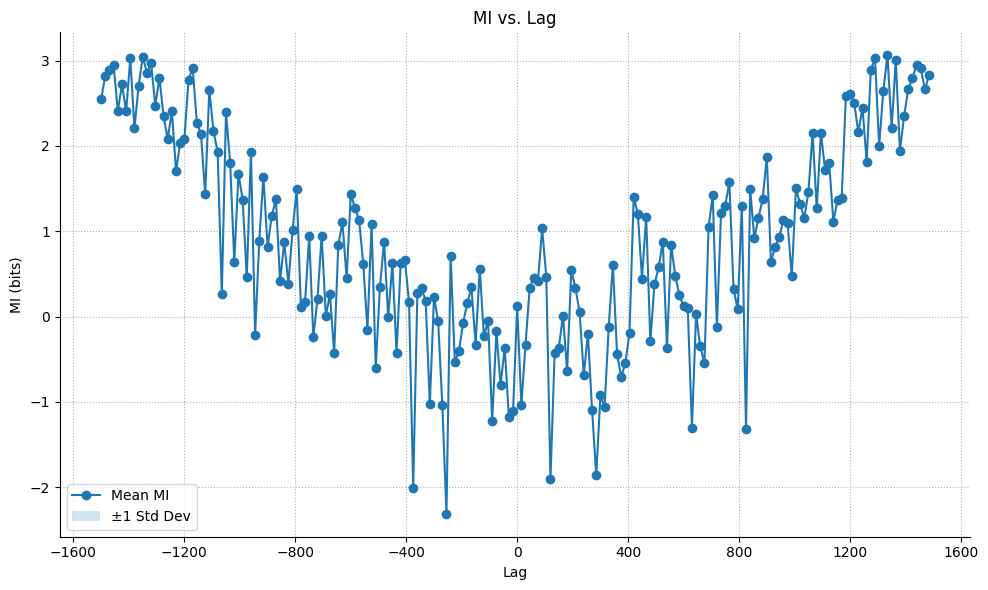

<Axes: title={'center': 'MI vs. Lag'}, xlabel='Lag', ylabel='MI (bits)'>

In [75]:
# Block 32 with smaller intervals (F3-T7)
results_large_lag.plot(show=True)

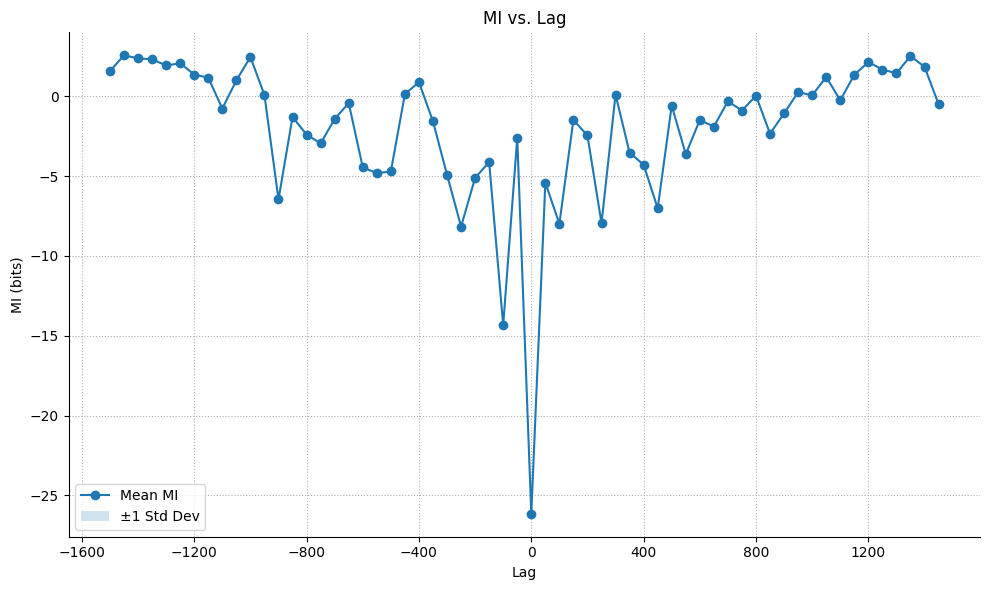

<Axes: title={'center': 'MI vs. Lag'}, xlabel='Lag', ylabel='MI (bits)'>

In [67]:
# Block 256 (F3-T7)
results_large_lag.plot(show=True)

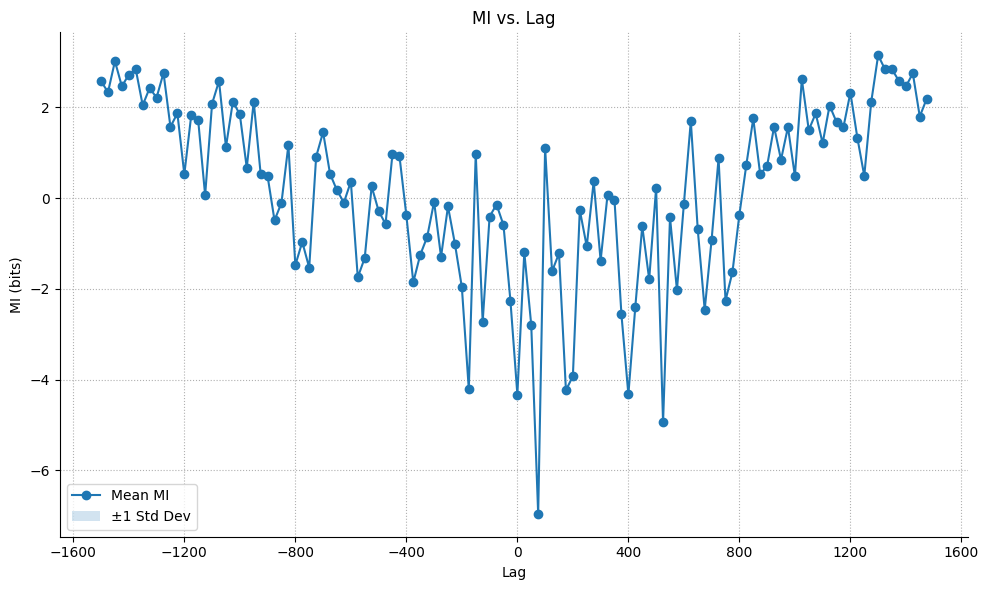

<Axes: title={'center': 'MI vs. Lag'}, xlabel='Lag', ylabel='MI (bits)'>

In [65]:
# Block 128 (F3-T7)
results_large_lag.plot(show=True)

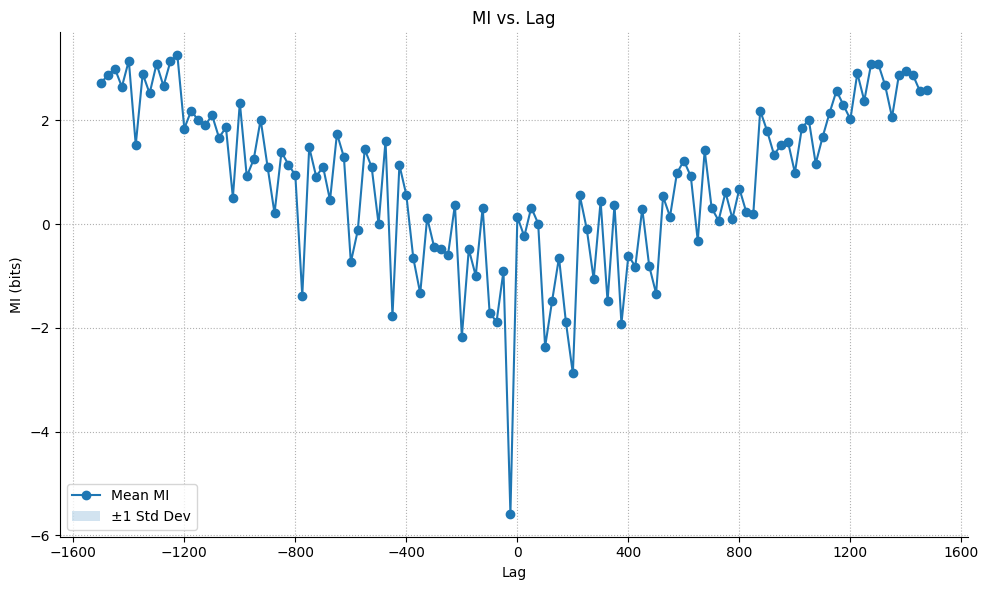

<Axes: title={'center': 'MI vs. Lag'}, xlabel='Lag', ylabel='MI (bits)'>

In [63]:
# Blocked 64 (F3-T7)
results_large_lag.plot(show=True)

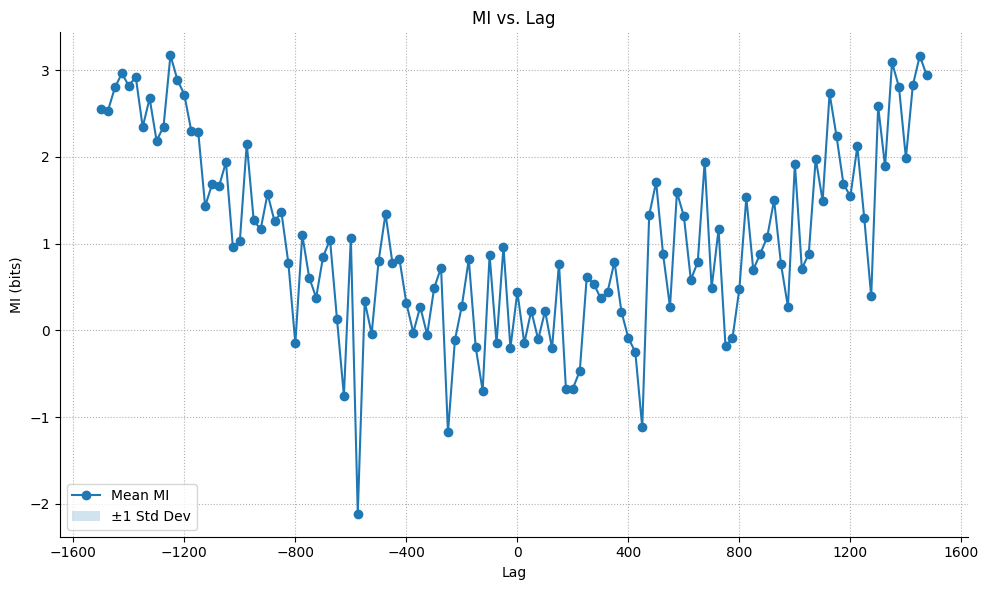

<Axes: title={'center': 'MI vs. Lag'}, xlabel='Lag', ylabel='MI (bits)'>

In [61]:
# Blocked 32 (F3-T7)
results_large_lag.plot(show=True)

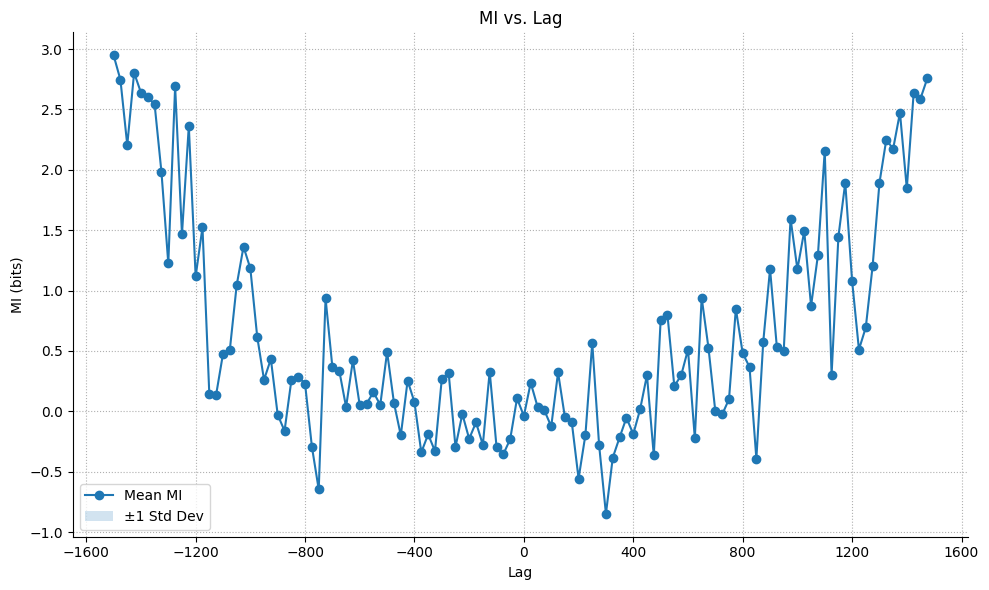

<Axes: title={'center': 'MI vs. Lag'}, xlabel='Lag', ylabel='MI (bits)'>

In [59]:
# Blocked 1 (F3-T7)
results_large_lag.plot(show=True)

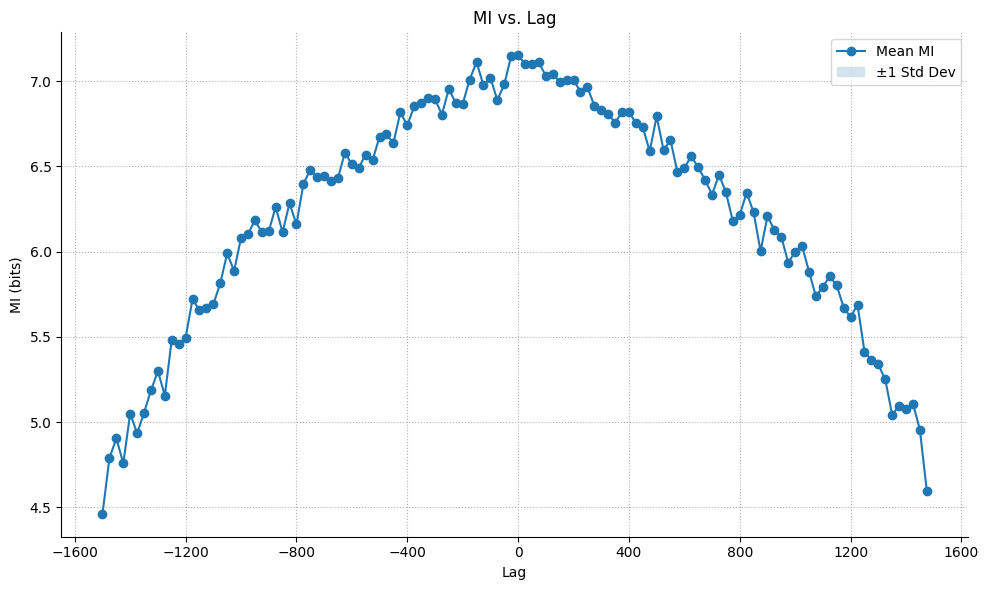

<Axes: title={'center': 'MI vs. Lag'}, xlabel='Lag', ylabel='MI (bits)'>

In [56]:
# Random 1, -1500 to 1500 lag (F3-T7)
results_large_lag.plot(show=True)

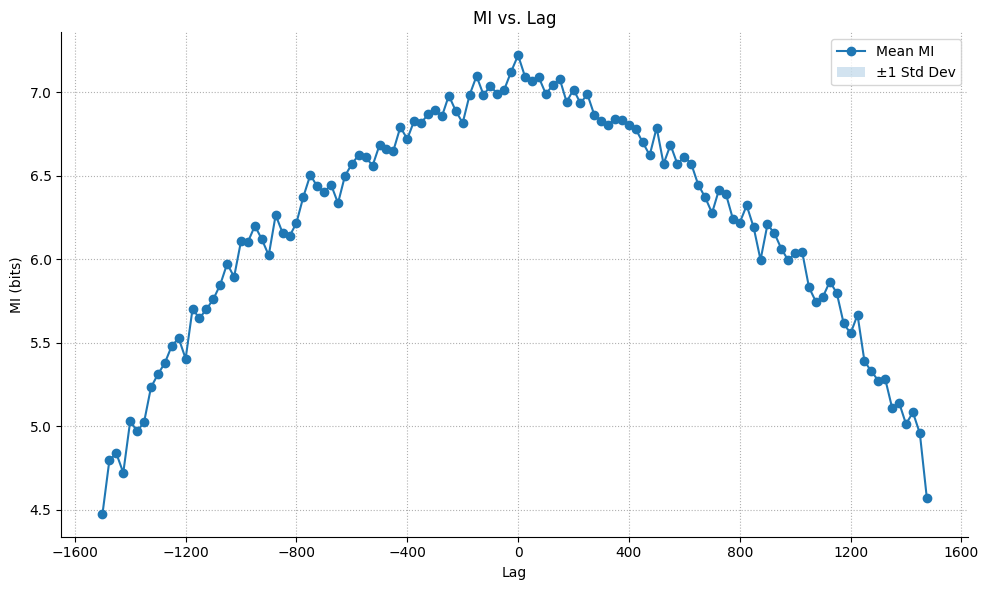

<Axes: title={'center': 'MI vs. Lag'}, xlabel='Lag', ylabel='MI (bits)'>

In [53]:
# Random 1, -1500 to 1500 (T7-T7)
results_large_lag.plot(show=True)

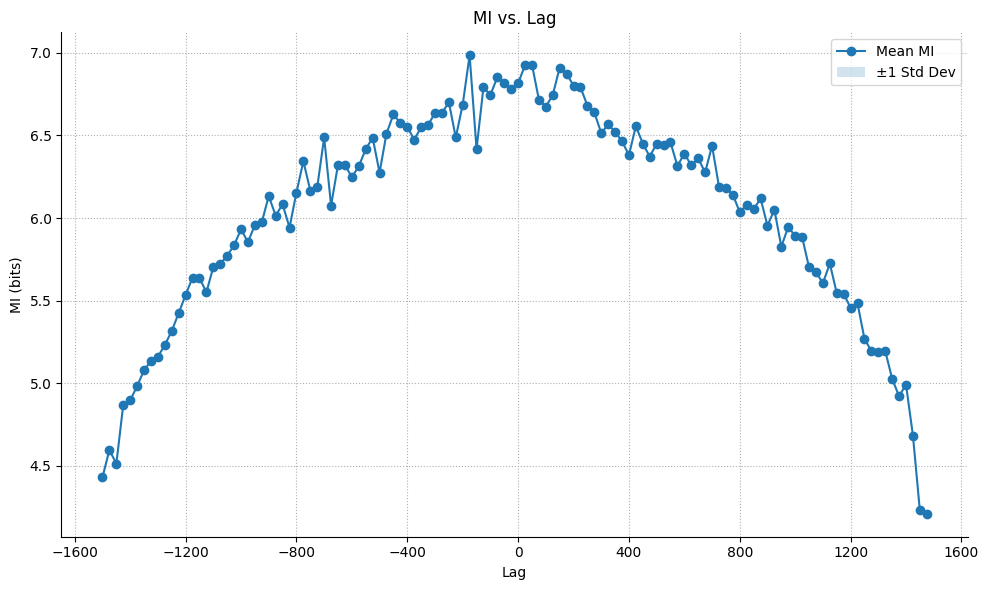

<Axes: title={'center': 'MI vs. Lag'}, xlabel='Lag', ylabel='MI (bits)'>

In [ ]:
# Random 1, -1500 to 1500 lag (CP3-T7)
results_large_lag.plot(show=True)

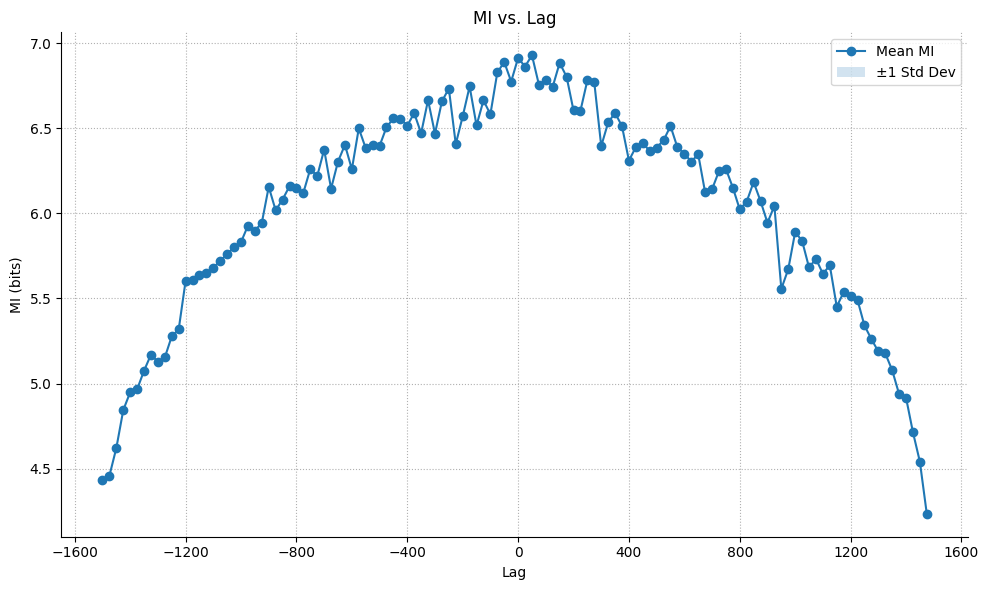

In [ ]:
# Random 64, -1500 to 1500 lag (C3-T7)
ax = results_large_lag.plot(show=True)

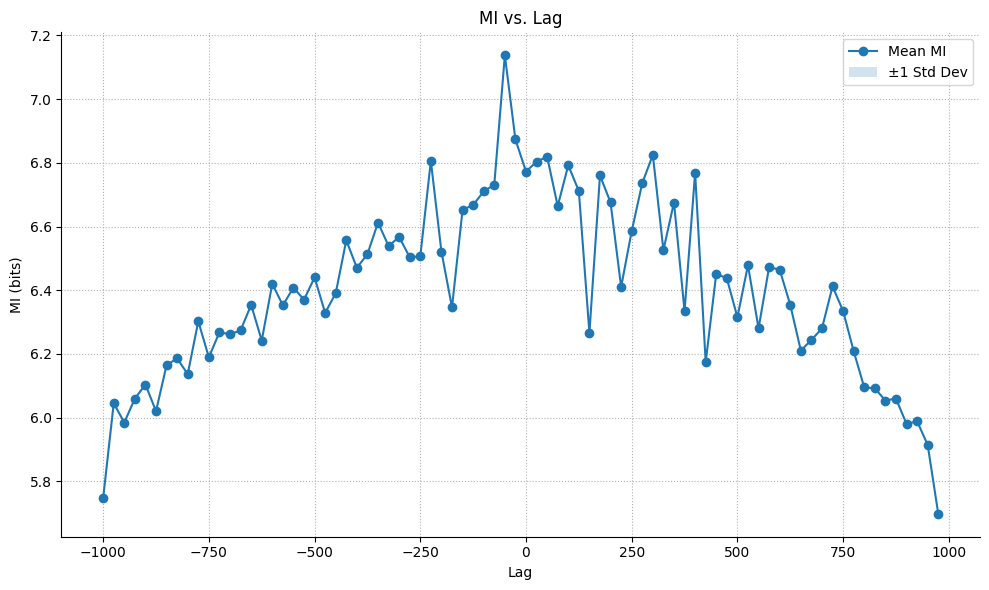

In [ ]:
# Random 64, -1000 to 1000 lag (C3-T7)
ax = results_large_lag.plot(show=True)

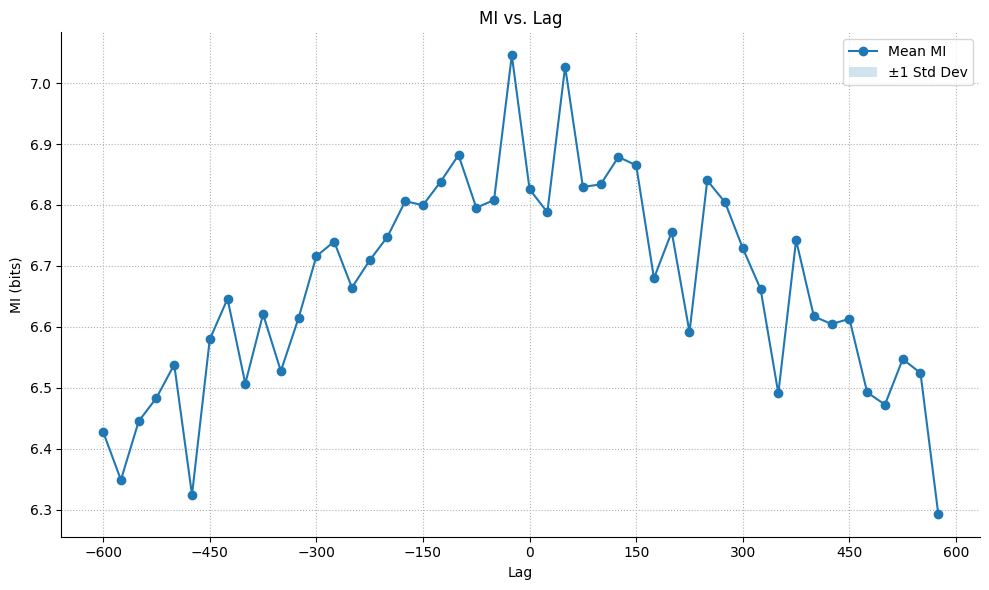

In [ ]:
# Random, 1
ax = results_large_lag.plot(show=True)

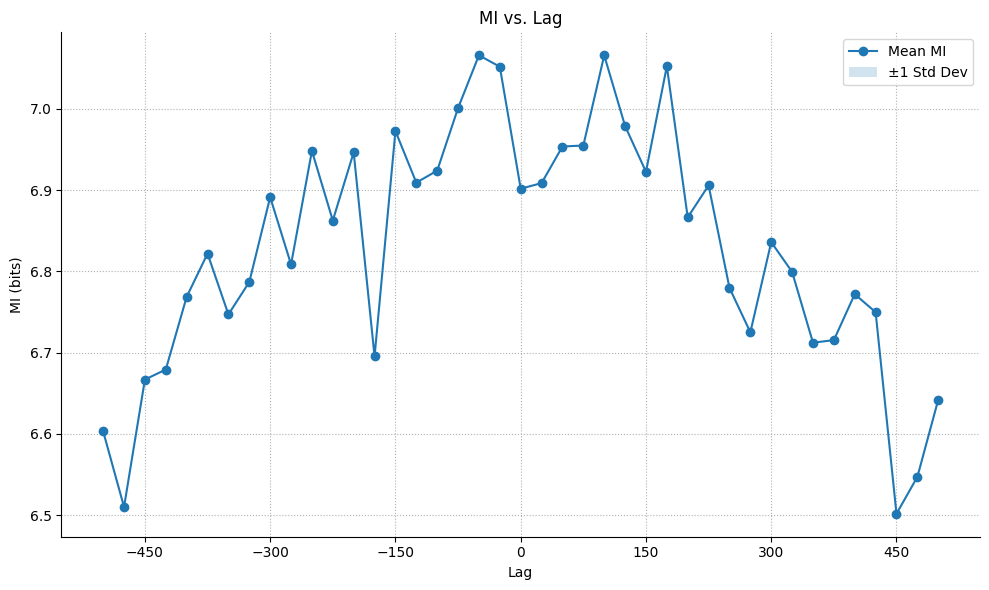

In [35]:
# Random splits, 32 window size
ax = results_large_lag.plot(show=True)

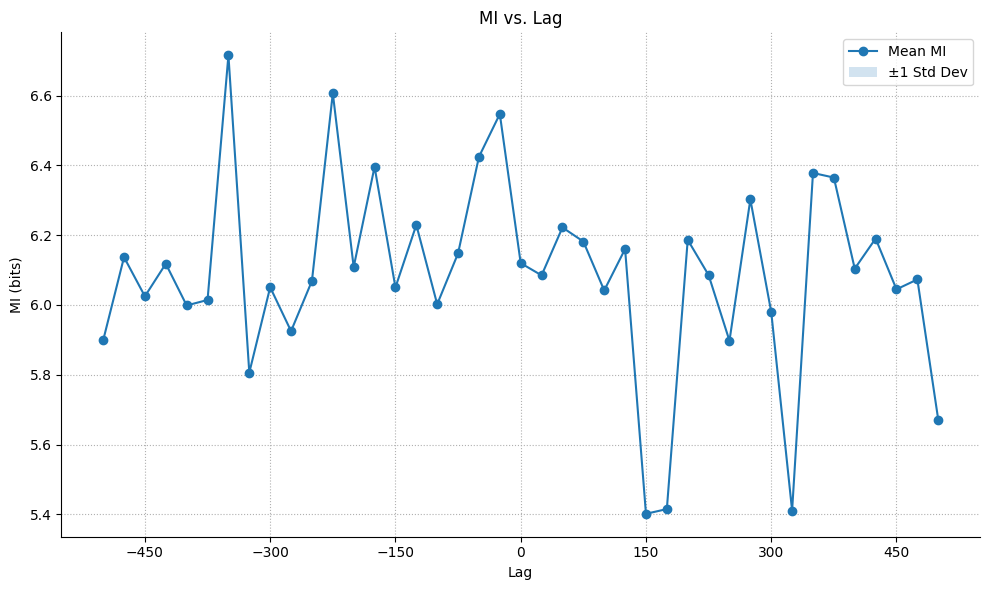

In [ ]:
# Random splits, 128 timepoint window size
ax = results_large_lag.plot(show=True)

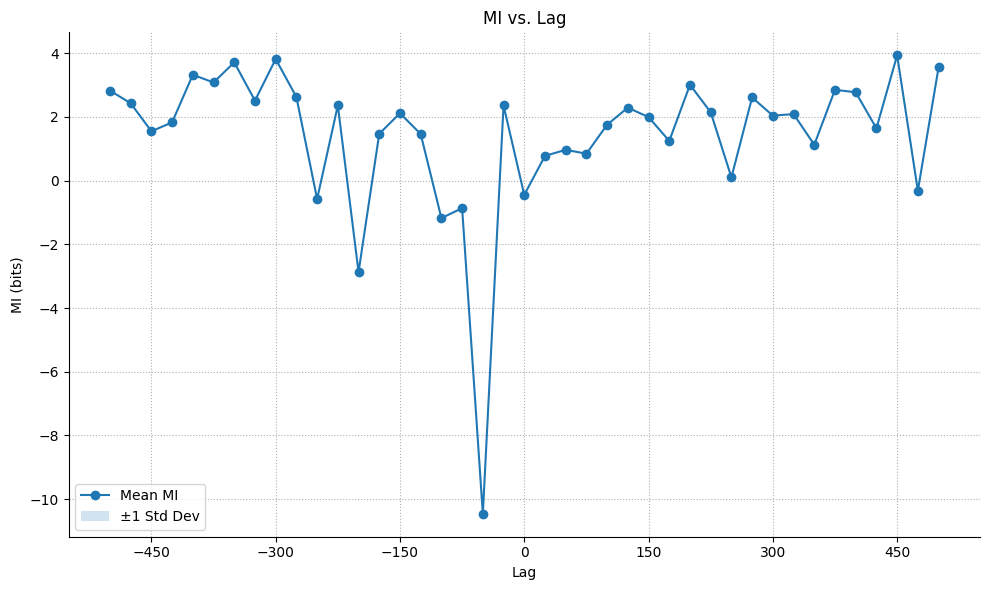

In [33]:
# Random splits, 500 window size
ax = results_large_lag.plot(show=True)